# Let's Import the Libraries to be used:

## 1. Let's download the libraries we'll be using

In [ ]:
%pip install --use-deprecated=legacy-resolver pycaret[full]


## 2. Let's import the libraries

In [73]:
import numpy as np
import  pandas as pd
import  seaborn as sns
import  scipy.stats as stats
import  matplotlib.pyplot as plt

from pycaret.regression import *

# To recap...


In the last notebook, we changed the structure and form of the explanatory variables to make machine learning easier, going through the whole feature engineering and feature selection pipeline.

In this notebook, we will test various machine learning models and check their performance on various metrics, choosing the one that performs best.

But first, let's re-access the data we had processed:

To-do: we need to iterate through each feature and each dataset

In [74]:
target_features=["yield_strength",
"ultimate_tensile_strength",]

In [110]:
target = target_features[0]

In [111]:
dataset = "multiple"

X_train = pd.read_csv('processed_data/multiple/processed_train_multiple.csv')

X_train[target] = pd.read_csv("data/train.csv")[target]

X_valid = pd.read_csv('processed_data/multiple/processed_validation_multiple.csv')

X_valid[target] = pd.read_csv("data/validation.csv")[target]


X_train = X_train.append(X_valid)
X_train = X_train.reset_index(drop=True)

X_test = pd.read_csv('processed_data/multiple/processed_test_multiple.csv')

X_test[target] = pd.read_csv("data/test.csv")[target]

In [112]:
X_train = X_train.dropna(subset=[target])
X_test = X_test.dropna(subset=[target])


In [113]:
def adjust_column_names(df):
    df.columns = df.columns.str.replace(' ', '_', regex=False)
    return df

X_train = adjust_column_names(X_train)
X_test = adjust_column_names(X_test)

In [114]:
X_train

,carbon_concentration_per_weight,silicon_concentration_per_weight,manganese_concentration_per_weight,sulphur_concentration_per_weight,phosphorus_concentration_per_weight,nickel_concentration_per_weight,hromium_concentration_per_weight,olybdenum_concentration_per_weight,anadium_concentration_per_weight,copper_concentration_per_weight,...,UMAP_3,UMAP_4,UMAP_5,UMAP_6,UMAP_7,group_2,group_3,group_4,group_5,yield_strength
0,0.041338,0.318183,-0.940660,2.008494,0.810673,-0.650290,0.389521,1.058723,-8.331571,-0.081933,...,-2.286480,-0.328668,0.190166,-0.223222,0.552553,0.0,0.0,0.0,0.0,546.0
1,0.082253,-0.831828,0.344920,0.261066,-0.676320,-0.849427,-0.629191,0.235490,-0.054829,-0.647698,...,2.947305,0.097238,0.041391,-2.671341,0.751181,-1.0,0.0,-1.0,0.0,523.0
4,0.241777,-0.458896,0.401684,0.000000,-0.676320,-0.849427,-0.052119,-0.437401,-0.054829,-0.647698,...,2.927941,0.093475,0.048349,-2.680265,0.717546,-1.0,0.0,-1.0,0.0,570.0
5,-0.126601,0.804490,-1.276573,0.261066,-0.676320,-0.238497,0.383865,0.595262,0.189005,-0.116554,...,0.433292,-1.764324,-0.378134,-1.833010,-0.813409,0.0,0.0,-1.0,0.0,446.0
7,-0.530854,-0.340231,-1.319213,0.000000,-0.489030,1.213324,-0.629191,-0.437401,-0.054829,-0.647698,...,-0.445194,2.178392,-0.182980,-0.279427,0.481822,-1.0,0.0,-1.0,0.0,457.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393,0.948759,-1.967616,-1.212894,1.126849,0.791997,-0.584118,0.392592,-0.012769,-1.212372,-0.733369,...,3.840508,-0.572374,-0.163702,-0.448747,-4.260528,0.0,0.0,0.0,0.0,596.0
1395,1.252235,-0.110862,0.192558,1.241017,0.978385,-0.672874,-0.587453,-0.407425,0.838713,0.243735,...,-0.025418,-1.304946,0.894688,-0.005145,3.332776,0.0,0.0,0.0,0.0,488.0
1397,-1.132371,-3.753689,-1.622096,0.000000,0.897443,-3.063973,0.358447,0.605723,-0.679578,-2.554574,...,-2.312937,-0.320566,0.196014,-0.205485,0.567385,0.0,0.0,0.0,0.0,473.0
1399,-0.083965,0.419674,-1.276573,0.261066,-0.676320,-0.295937,0.341003,0.638152,0.395644,-0.041128,...,0.521462,-1.739721,-0.395866,-1.867843,-0.893602,0.0,0.0,-1.0,0.0,483.0


# Choosing the Best Model

To check a wide range of models, we're going to use Pycaret, an AutoML library.
With the data processed, we can start testing possible model candidates.

In [115]:
exp_clf101 = setup(data = X_train,
                   target = target,
                   normalize = True,
                   transformation = True,
                   session_id=123,
                   feature_selection=True,
                   index=False,
                   remove_multicollinearity = True,
                   multicollinearity_threshold = 0.95,
                   n_features_to_select=0.6)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3876
[LightGBM] [Info] Number of data points in the train set: 459, number of used features: 42
[LightGBM] [Info] Start training from score 507.419172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

,Description,Value
0,Session id,123
1,Target,yield_strength
2,Target type,Regression
3,Original data shape,"(657, 43)"
4,Transformed data shape,"(657, 26)"
5,Transformed train set shape,"(459, 26)"
6,Transformed test set shape,"(198, 26)"
7,Numeric features,42
8,Preprocess,True
9,Imputation type,simple


## Comparing Models


To compare the models, we will first use the R2 metric. A Kfold will be used for cross validation with k=10. Let's now test several different models and see which one works best on the desired dataset:

In [116]:
best_models = compare_models(sort = 'r2',n_select = 4)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:24:10
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,31.8803,2027.0189,44.4778,0.7647,0.0847,0.0622,0.3860
et,Extra Trees Regressor,31.1764,2058.3155,44.9228,0.7595,0.0858,0.0614,0.3740
xgboost,Extreme Gradient Boosting,35.9842,2547.2708,49.4214,0.7070,0.0941,0.0702,0.5260
gbr,Gradient Boosting Regressor,35.9893,2439.4233,48.9576,0.7063,0.0931,0.0705,0.4310
rf,Random Forest Regressor,35.7667,2663.6999,51.1122,0.6896,0.0971,0.0703,0.5970
ada,AdaBoost Regressor,42.6337,3117.7926,55.5154,0.6409,0.1081,0.0860,0.3030
knn,K Neighbors Regressor,40.4780,3209.1395,55.8655,0.6224,0.1071,0.0798,0.2750
br,Bayesian Ridge,46.2034,3956.0666,62.3639,0.5453,0.1174,0.0906,0.2500
llar,Lasso Least Angle Regression,46.2195,3983.6147,62.5585,0.5428,0.1179,0.0906,0.1990
lasso,Lasso Regression,46.2190,3983.5279,62.5579,0.5428,0.1179,0.0906,0.2040


In [117]:
best_models[0].feature_names_in_

array(['carbon_concentration_per_weight',
       'silicon_concentration_per_weight',
       'manganese_concentration_per_weight',
       'sulphur_concentration_per_weight',
       'phosphorus_concentration_per_weight',
       'nickel_concentration_per_weight',
       'hromium_concentration_per_weight',
       'olybdenum_concentration_per_weight',
       'copper_concentration_per_weight',
       'tungsten_concentration_per_weight',
       'oxygen_concentration_per_parts_per_million_by_weight',
       'titanium_concentration_per_parts_per_million_by_weight',
       'nitrogen_concentration_per_parts_per_million_by_weight',
       'aluminium_concentration_per_parts_per_million_by_weight',
       'tin_concentration_per_parts_per_million_by_weight',
       'arsenic_concentration_per_parts_per_million_by_weight',
       'antimony_concentration_per_parts_per_million_by_weight',
       'post_weld_heat_treatment_temperature', 'elongation',
       'reduction_of_area', 'charpy_temperature',
      

In [118]:
blend_model = blend_models(best_models,fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,33.9959,2287.2472,47.8252,0.7469,0.0836,0.0610
1,40.1689,2854.0922,53.4237,0.7138,0.0962,0.0762
2,34.5993,2603.0321,51.0199,0.8275,0.0916,0.0645
3,24.4928,1166.0621,34.1477,0.8127,0.0688,0.0505
4,26.4478,1243.2669,35.2600,0.8540,0.0724,0.0557
5,29.9113,1845.5914,42.9603,0.8058,0.0860,0.0615
6,35.4084,2764.1519,52.5752,0.6998,0.1083,0.0730
7,30.6069,1820.0390,42.6619,0.6693,0.0799,0.0599
8,27.7429,1291.2665,35.9342,0.8358,0.0711,0.0563


In [119]:
final_blend_model = finalize_model(blend_model)

# Evaluating

In [120]:
weld_pred = predict_model(final_blend_model,data=X_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,25.5365,1726.0359,41.5456,0.8111,0.0704,0.0486


In [121]:
y_pred = weld_pred['prediction_label']
y_true = weld_pred[target]

In [122]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from typing import List

def plot_results(y_true: List[float], y_pred: List[float]) -> None:
    """
    Plot both the standardized residuals plot and the predicted vs true values plot side by side,
    with a common title that includes the R2 score.

    Args:
        y_true: List of true values.
        y_pred: List of predicted values.

    Returns:
        None

    Raises:
        ValueError: If y_true and y_pred have different lengths.
    """

    # Check if lengths are the same
    if len(y_true) != len(y_pred):
        raise ValueError("Lengths of y_true and y_pred must be the same.")

    # Calculate the residuals
    residuals = np.array(y_true) - np.array(y_pred)

    # Standardize the residuals
    std_residuals = residuals / np.std(residuals)

    # Calculate the R2 score
    r2 = r2_score(y_true, y_pred)

    # Create the subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Common title with R2 score
    fig.suptitle(fr"Evaluation of TGV Model to Average train delay time - = {r2:.2f}", fontsize=18)

    # Plot for standardized residuals
    axes[0].scatter(y_pred, std_residuals, c='blue')
    axes[0].axhline(y=0, color='r', linestyle='--')
    axes[0].set_xlabel("Predicted Values", fontsize=14)
    axes[0].set_ylabel("Standardized Residuals", fontsize=14)
    axes[0].set_title("Standardized Residuals Plot", fontsize=16)

    # Plot for y_true vs y_pred
    axes[1].scatter(y_pred, y_true, c='blue', label='Data')
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', label='x=y')
    axes[1].set_xlabel("Predicted Values", fontsize=14)
    axes[1].set_ylabel("True Values", fontsize=14)
    axes[1].set_title("Predicted vs True Values", fontsize=16)
    axes[1].legend(fontsize=12)

    # Show the plots
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


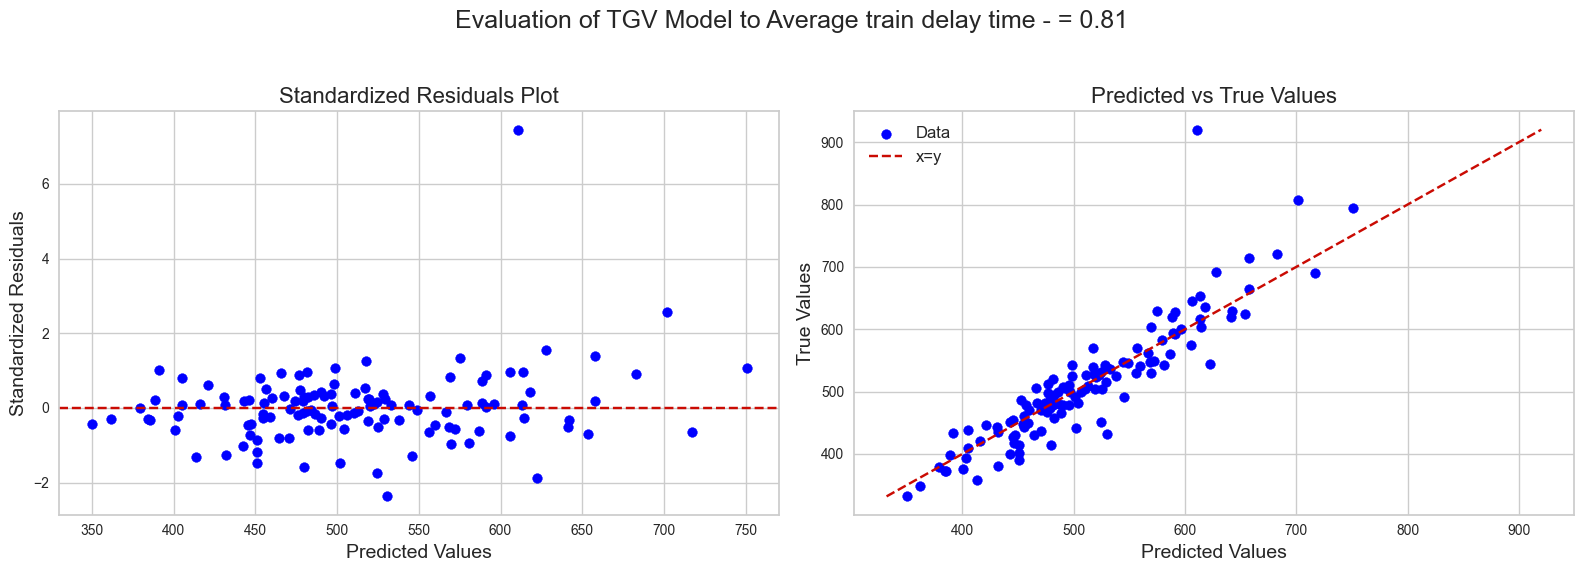

In [123]:
plot_results(y_true,y_pred)